# Gen-AI Project: Image Colorization with Autoencoders
This Gen-AI project demonstrates how autoencoders can be used to add color to grayscale images. Autoencoders are neural networks that learn to compress and reconstruct data, making them ideal for tasks like image colorization.

For colorization, the encoder extracts features from grayscale images, and the decoder predicts the color channels. By learning from a variety of images, the model can generate realistic colors for black-and-white photos.

**Let's get started and build our AutoEncoder!**

In [1]:
import warnings
warnings.filterwarnings('ignore')

**Importing essential libraries for the project**

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, InputLayer, BatchNormalization, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Preparing the Dataset
We have a collection of grayscale and colored images from **Kaggle**. We'll resize and normalize these images to ensure uniformity for model training.

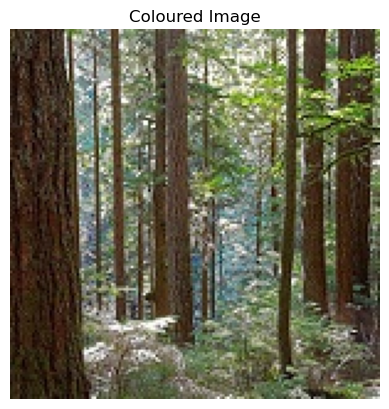

In [ ]:
color_images_path = '../input/landscape-image-colorization/landscape Images/color/'
color_image_paths = os.listdir(color_images_path)
sample_color_img = plt.imread(os.path.join(color_images_path, np.random.choice(color_image_paths)))
plt.imshow(sample_color_img)
plt.axis('off')
plt.title("Sample Colored Image")
plt.show()

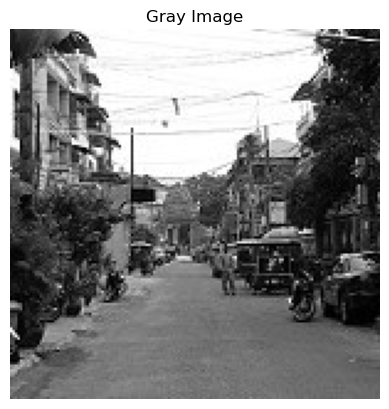

In [ ]:
gray_images_path = '../input/landscape-image-colorization/landscape Images/gray/'
gray_image_paths = os.listdir(gray_images_path)
sample_gray_img = plt.imread(os.path.join(gray_images_path, np.random.choice(gray_image_paths)))
plt.imshow(sample_gray_img, cmap='gray')
plt.axis('off')
plt.title("Sample Grayscale Image")
plt.show()

#### Let's preview some landscape images and their grayscale counterparts from the dataset.

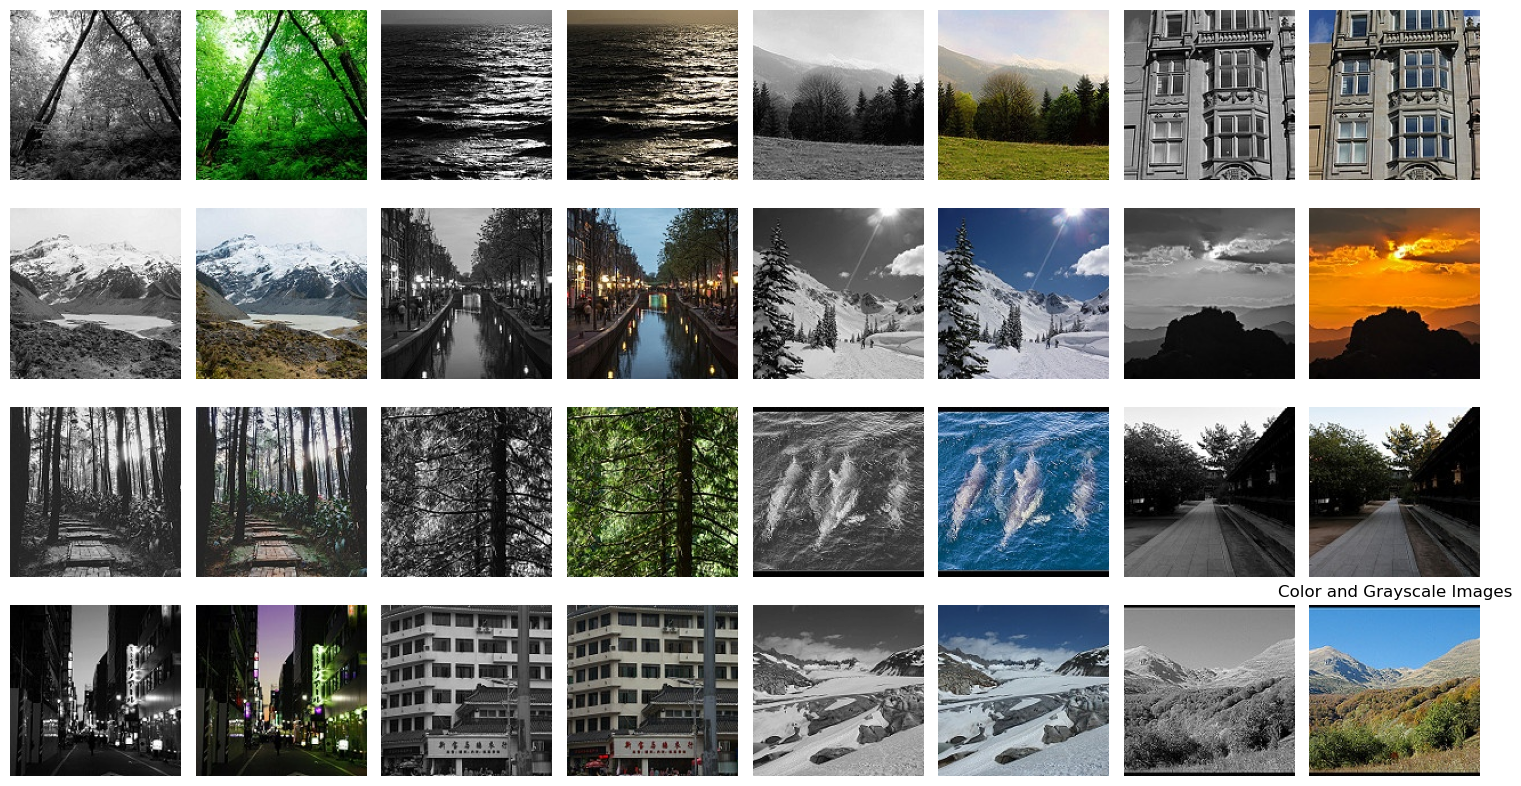

In [ ]:
plt.figure(figsize=(15,20))
for i in range(1,33):
    img_idx = np.random.randint(len(color_image_paths))
    plt.subplot(10,8,i)
    if i % 2 == 0:
        plt.imshow(plt.imread(os.path.join(color_images_path, color_image_paths[img_idx])))
        plt.axis('off')
    else:
        plt.imshow(plt.imread(os.path.join(gray_images_path, gray_image_paths[img_idx])), cmap='gray')
        plt.axis('off')
plt.tight_layout()
plt.suptitle("Color and Grayscale Samples")
plt.show()

### Data Preprocessing
- Load each image using OpenCV (`cv2.imread`).
- Resize images to a fixed size for consistency.
- Normalize pixel values to [0, 1] for neural network input.
- Convert images to arrays using Keras utilities.

In [ ]:
%%time
color_images = []
gray_images = []
IMG_SIZE = 120
for image_path in color_image_paths:
    img = cv2.cvtColor(cv2.imread(os.path.join(color_images_path, image_path)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), cv2.INTER_CUBIC)
    img = img.astype('float32') / 255.0
    color_images.append(img_to_array(img))

for image_path in gray_image_paths:
    img = cv2.imread(os.path.join(gray_images_path, image_path))
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), cv2.INTER_CUBIC)
    img = img.astype('float32') / 255.0
    gray_images.append(img_to_array(img))

CPU times: user 8.8 s, sys: 3.4 s, total: 12.2 s
Wall time: 1min 19s


### Splitting Data for Training and Testing
We'll use the first 5000 images for training and the rest for testing.

In [7]:
X_train, Y_train = color_images[:5000], gray_images[:5000]
X_test, Y_test = color_images[5000:], gray_images[5000:]

Next, we'll reshape both grayscale and color images to fit the input requirements of our autoencoder. The shape (num_images, IMG_SIZE, IMG_SIZE, 3) ensures compatibility with models expecting RGB channels, even for grayscale data.

In [ ]:
%%time
with tf.device('/GPU:0'):
    gray = np.reshape(Y_train, (len(Y_train), IMG_SIZE, IMG_SIZE, 3))
    color = np.reshape(X_train, (len(X_train), IMG_SIZE, IMG_SIZE, 3))
    print('Training color image shape:', color.shape)
    test_gray = np.reshape(Y_test, (len(Y_test), IMG_SIZE, IMG_SIZE, 3))
    test_color = np.reshape(X_test, (len(X_test), IMG_SIZE, IMG_SIZE, 3))
    print('Validation color image shape:', test_color.shape)

Train color image shape: (5000, 120, 120, 3)
Valid color image shape: (2129, 120, 120, 3)
CPU times: user 1.89 s, sys: 1.41 s, total: 3.3 s
Wall time: 4.83 s


# Model Architecture
Autoencoders are neural networks that learn compressed representations of data and reconstruct the original input. They are especially useful for tasks like image colorization.
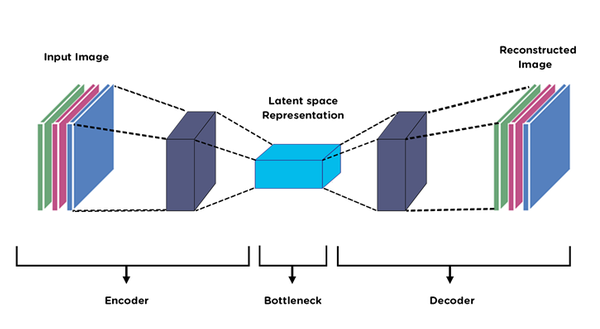

**Encoder:** The encoder uses convolutional layers with batch normalization and max pooling to extract features from images. The number of filters increases at each stage, allowing the network to capture complex patterns.

In [ ]:
%%time
with tf.device('/GPU:0'):
    Encoder = Sequential([
        InputLayer(input_shape=(120, 120, 3), name="Input_layer"),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, padding='same', activation='relu', kernel_initializer='lecun_normal', name="Conv_01"),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_initializer='lecun_normal', name="Conv_02"),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer='lecun_normal', name="Conv_03"),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(512, kernel_size=3, padding='same', activation='relu', kernel_initializer='lecun_normal', name="Conv_04"),
        BatchNormalization(),
        MaxPooling2D(),
    ])

CPU times: user 274 ms, sys: 226 ms, total: 500 ms
Wall time: 559 ms


**Decoder:** The decoder reconstructs the image from the encoded features. It uses transposed convolutional layers and batch normalization to upsample and restore the original image dimensions.

In [ ]:
%%time
with tf.device('/GPU:0'):
    Decoder = Sequential([
        InputLayer(input_shape=(Encoder.output_shape[-3:]), name='Decoder_input'),
        BatchNormalization(),
        Conv2DTranspose(256, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer='lecun_normal', name='ConvT_01'),
        BatchNormalization(),
        Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='lecun_normal', name='ConvT_02'),
        BatchNormalization(),
        Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='lecun_normal', name='ConvT_03'),
        BatchNormalization(),
        Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='glorot_normal', name='ConvT_04'),
        Reshape([120, 120, 3])
    ])

CPU times: user 126 ms, sys: 1.68 ms, total: 128 ms
Wall time: 130 ms


# Model Training
Now, we'll combine the encoder and decoder to create the autoencoder model for image colorization.

In [ ]:
%%time
with tf.device('/GPU:0'):
    AutoEncoder = Sequential([Encoder, Decoder])
    AutoEncoder.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    earlystop = [EarlyStopping(patience=3, restore_best_weights=True)]
    history = AutoEncoder.fit(gray, color, epochs=25, verbose=0, validation_data=(test_gray, test_color), batch_size=12, callbacks=earlystop)

CPU times: user 3min 12s, sys: 9.17 s, total: 3min 21s
Wall time: 4min 16s


With training complete, let's use the autoencoder to colorize some images and evaluate its performance.

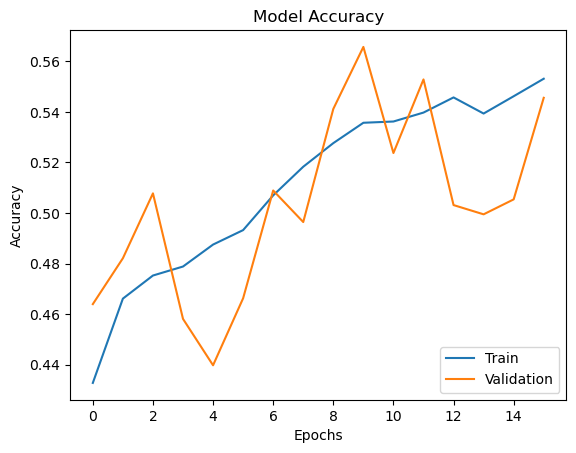

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

**The model achieves around 60% accuracy on the validation set.**

Let's visualize the colorization results on random samples from the dataset.

1/1 [==============================] - 0s 19ms/step


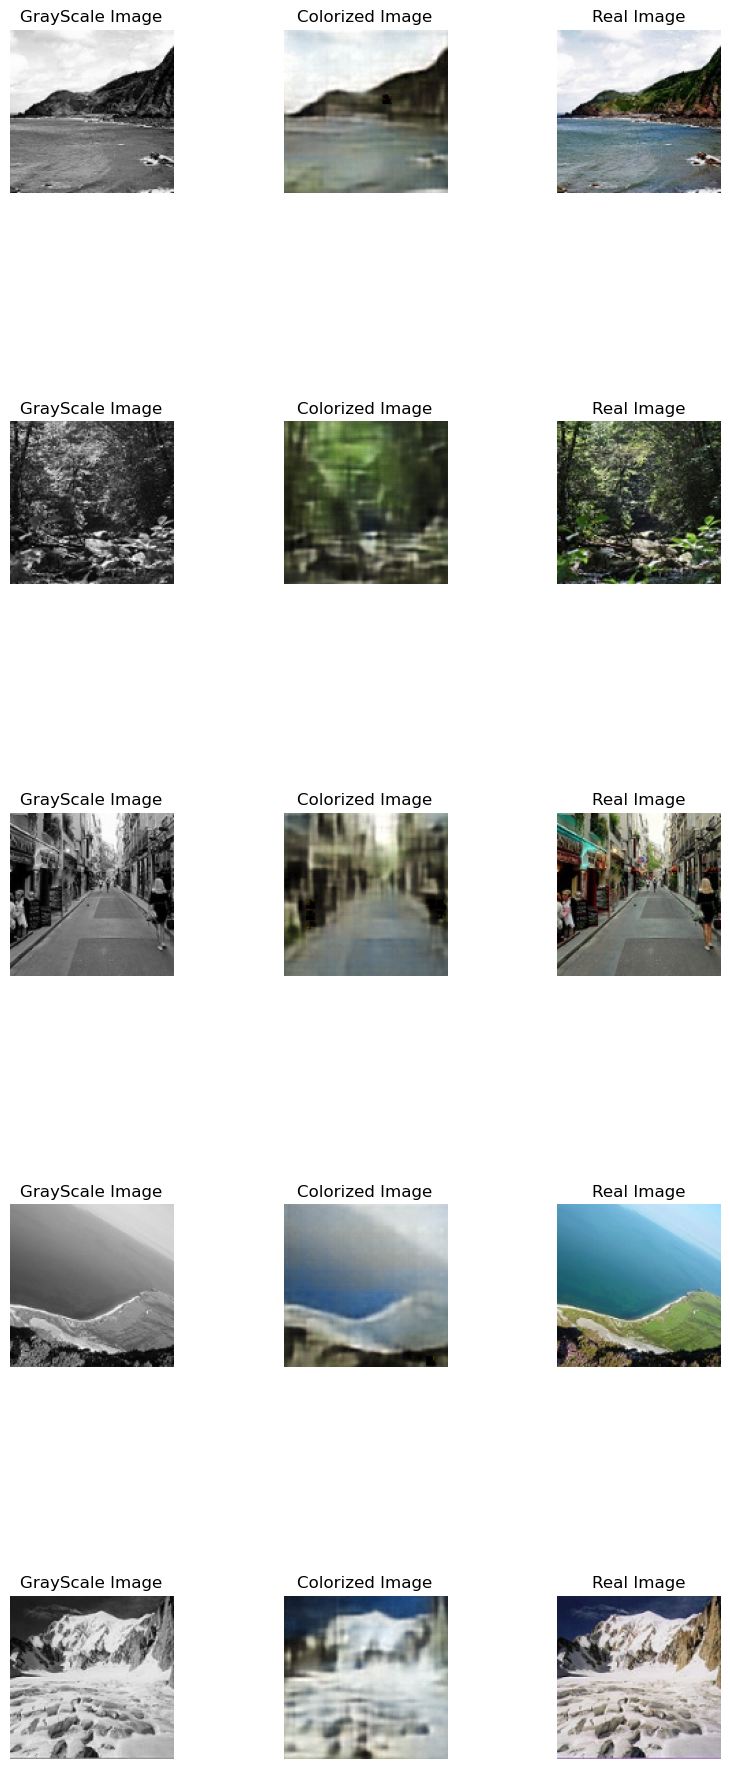

In [ ]:
plt.figure(figsize=(10, 25))
for i in range(1, 30, 6):
    idx = np.random.randint(5000)
    real_color = X_train[idx]
    gray_img = Y_train[idx]
    predicted_color = AutoEncoder.predict(gray_img[np.newaxis, ...])[0]
    plt.subplot(10, 3, i)
    plt.title("Grayscale")
    plt.imshow(gray_img)
    plt.axis('off')
    plt.subplot(10, 3, i + 1)
    plt.title("Colorized")
    plt.imshow(predicted_color)
    plt.axis('off')
    plt.subplot(10, 3, i + 2)
    plt.title("Original Color")
    plt.imshow(real_color)
    plt.axis('off')